# Validation test suite for dlm regression models within DLMMC

**In this notebook we run through the suite of DLM models in DLMMC, generate mock data for each model in turn and then perform inference on those mock data. This acts as both a test suite to check the install has worked (ie all of the models run through without error), and aslo serves as a set of validation demonstrations (are the input parameters recovered, within posterior uncertainties).** 

**NOTE: This notebook is NOT a detailed tutorial for how to use the code in this package: for a step-by-step tutorial see `dlm_tutorial.ipynb`. However, once you have worked through the tutorial for running the vanilla DLM model, this notebook may be a useful guide for running the other DLM models in the suite.**

## Import the required packages

In [1]:
# Import required modules
import pystan
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.interpolate as interpolate
import netCDF4
import pickle
import scipy.stats as stats
from utils.utils import *
from utils.dlm import *
%matplotlib inline

## Set time axis and import the regressors to be used in the tests

**Here we import some standard regressors that are provided in the `regressors/` folder, that we will use for the various validation tests. We use standard indicies for: El Nino Southern Oscillation (ENSO), Solar activity (Solar), the Quasi-Biennial Oscillation (QBO; two indicies QBO30 and QBO50) and stratospheric aerosol optical depth (SAOD) for volcanic eruptions.**

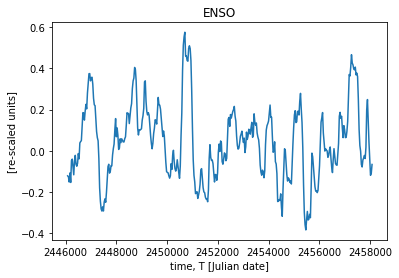

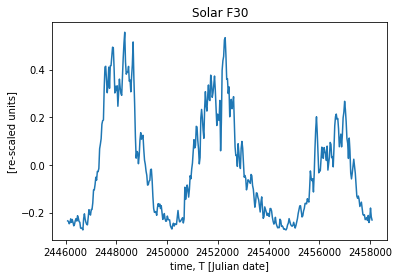

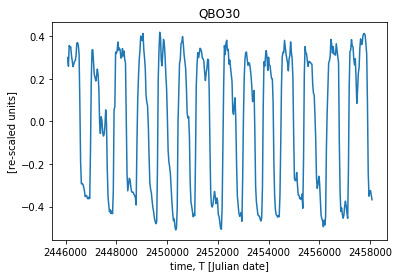

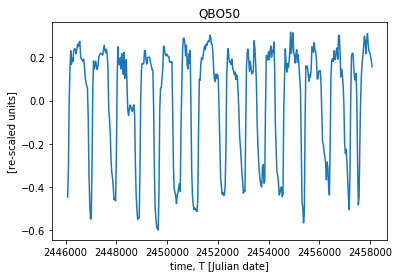

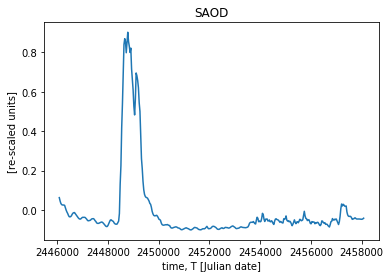

In [2]:
# Set the time array for all the tests
T = np.arange(2446081, 2458104, 30, dtype=np.float32)
nt = len(T)

# Import the regressors for the tests

# ENSO
regressor_data = np.loadtxt('regressors/enso_mei_1950_201802.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
enso = Y(T)

# SOLAR
regressor_data = np.loadtxt('regressors/flux_F30_monthly_195111_201803_absolute.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
solar = Y(T)

# QBO30
regressor_data = np.loadtxt('regressors/multi_qbo30_1953_2018.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
qbo30 = Y(T)

# QBO50
regressor_data = np.loadtxt('regressors/multi_qbo50_1953_2018.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
qbo50 = Y(T)

# SAOD
regressor_data = np.loadtxt('regressors/sad_1979_2017_10deg_60S_60N.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
saod = Y(T)

# Stack the regressors into big 2d array
regressors = np.column_stack([enso, solar, qbo30, qbo50, saod]) # Stack of all the regressors together in a 2d array
regressor_names = ['ENSO', 'SOLAR', 'QBO30', 'QBO50', 'SAOD']

# Plot all the regressors to check they look OK
plt.plot(T, enso)
plt.title('ENSO')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, solar)
plt.title('Solar F30')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, qbo30)
plt.title('QBO30')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, qbo50)
plt.title('QBO50')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, saod)
plt.title('SAOD')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

# Test 1: model `dlm_vanilla_ar1`

## (1) Choose hyper-parameters and priors, generate random mock data realization
## (2) Fit DLM model to the mock data
## (3) Plot the inferred DLM model components against the (mock) inputs

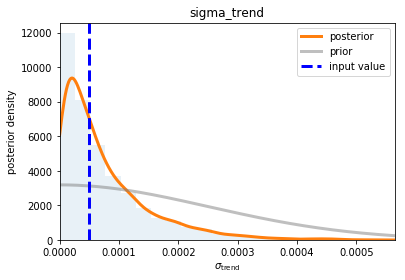

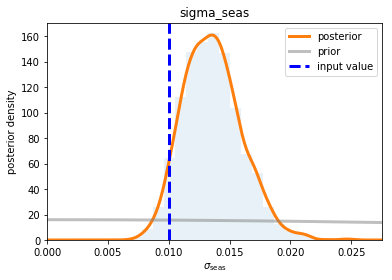

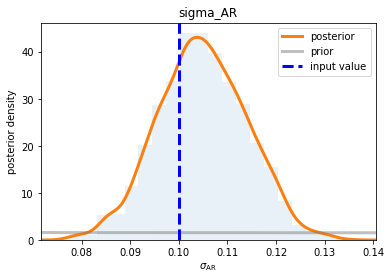

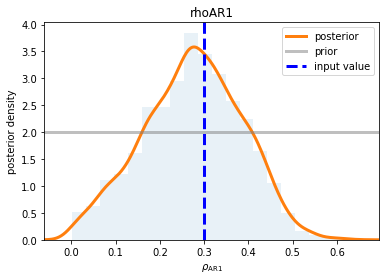

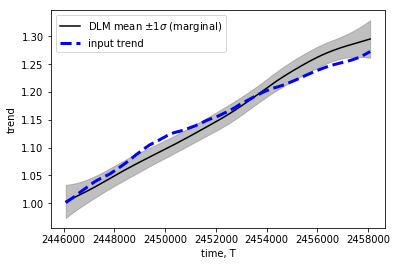

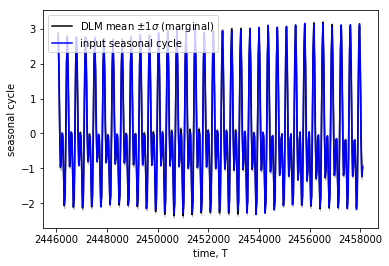

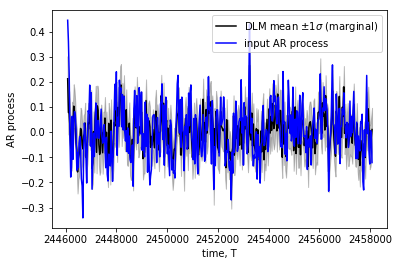

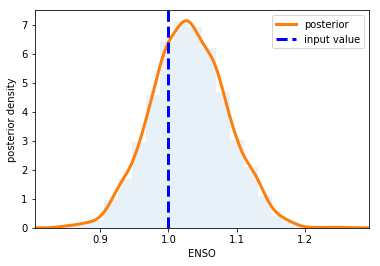

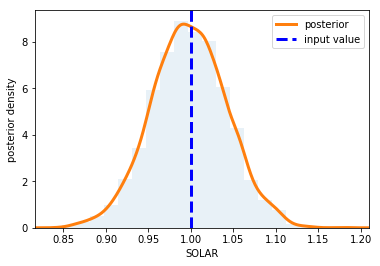

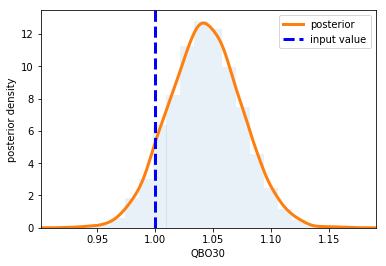

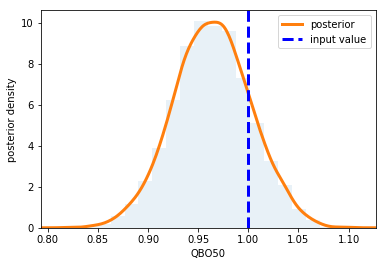

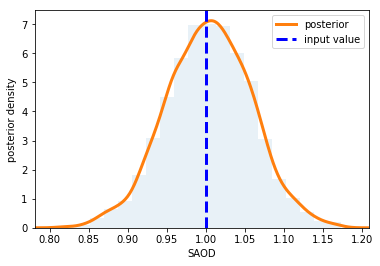

In [3]:
# Set the random seed for re-producebility
np.random.seed(0)

# Set the "true" input values of the hyper parameters for the test
sigma_trend = 5e-5
sigma_seas = 1e-2
sigma_AR = 0.1
rhoAR1 = 0.3

# Set "true" input x0: initial value of state vector
nx = len(regressors.T)+7
x0 = np.concatenate([np.array([1, 1e-3]), np.ones(nx-2)])

# Set the standard deviations for the observational uncertainties
s = np.ones(nt+1)*0.1

# Set the prior parameters
S = 10. # Gaussian prior std-dev for initial state vector components x0
sigma_trend_prior = 2.5e-4
sigma_seas_prior = 5e-2
sigma_AR_prior = 0.5

# Generate realization of state x and observations y
x, d = simulate_x_y_dlm_vanilla_ar1(x0, sigma_trend, sigma_seas, sigma_AR, rhoAR1, regressors, S, s**2, nt, nx)

# Pull the various components from the simulated state vector
trend = x[0,1:]
slope = x[1,1:]
seasonal_cycle = x[2,1:] + x[4,1:]
ar = x[-1,1:]
regressor_coefficients = x[6:6+len(regressors.T), 1]

# What is the range of the data (NB: hyper-parameters are defined in units of the rescaled data, ie., /(max(d) - min(d)) )
data_range = max(d[1:]) - min(d[1:])

# Import the DLM model
dlm_model = pickle.load(open('models/dlm_vanilla_ar1.pkl', 'rb'))

# Set the data and initialization of parameters that are fed into the DLM

# Input data: this is a dictionary of all of the data/inputs that the DLM model needs (descriptions below)
input_data = {
                    'time_series':d[1:], # float[N] data vector
                    'stddev':s[1:], # float[N] std-dev error bars
                    'N':len(d[1:]), # (int) number of time-steps in the time-series
                    'nreg':len(regressors.T), # (int) number of regressors
                    'regressors':regressors, # float[N, nreg] the regressors
                    'sampling':sampling_rate("monthly"), # must be "daily", "monthly", or "annual"
                    'S':S, # prior variance on the regression coefficients
                    'sigma_trend_prior':sigma_trend_prior/data_range, # std-dev of the half-Gaussian prior on sigma_trend
                    'sigma_seas_prior':sigma_seas_prior/data_range, # std-dev of the half-Gaussian prior on sigma_seas
                    'sigma_AR_prior':sigma_AR_prior/data_range # std-dev of the half_Gaussian prior on the AR1 process std-dev 
                }

# Initialization: Initial guess values for the hyper-parameters
initial_state = {
                 'sigma_trend':sigma_trend/data_range,
                 'sigma_seas':sigma_seas/data_range,
                 'sigma_AR':sigma_AR/data_range,
                 'rhoAR1':rhoAR1,
                }

# Ok, let's run it
fit = dlm_model.sampling(data=input_data, iter=4000, warmup=1000, chains=1, init = [initial_state], verbose=True, pars=('sigma_trend', 'sigma_seas', 'sigma_AR', 'rhoAR1', 'trend', 'slope', 'beta', 'seasonal', 'ar'))

# Plot the results:

## Plot posteriors for the DLM hyper parameters

sigma_trend_samples = fit.extract()['sigma_trend']*data_range
kde = stats.gaussian_kde(sigma_trend_samples)
x = np.linspace(0, max(sigma_trend_samples)*1.1, 300)
plt.hist(sigma_trend_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_trend_prior**2))*np.exp(-x**2/(2*sigma_trend_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_trend, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_trend')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{trend}$')
plt.legend()
plt.show()

sigma_seas_samples = fit.extract()['sigma_seas']*data_range
kde = stats.gaussian_kde(sigma_seas_samples)
x = np.linspace(0, max(sigma_seas_samples)*1.1, 300)
plt.hist(sigma_seas_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_seas_prior**2))*np.exp(-x**2/(2*sigma_seas_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_seas, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_seas')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{seas}$')
plt.legend()
plt.show()

sigma_AR_samples = fit.extract()['sigma_AR']*data_range
kde = stats.gaussian_kde(sigma_AR_samples)
x = np.linspace(min(sigma_AR_samples) - np.ptp(sigma_AR_samples)*0.1, max(sigma_AR_samples) + np.ptp(sigma_AR_samples)*0.1, 300)
plt.hist(sigma_AR_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_AR_prior**2))*np.exp(-x**2/(2*sigma_AR_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_AR, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_AR')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{AR}$')
plt.legend()
plt.show()

rhoAR1_samples = fit.extract()['rhoAR1']
kde = stats.gaussian_kde(rhoAR1_samples)
x = np.linspace(min(rhoAR1_samples) - np.ptp(rhoAR1_samples)*0.1, max(rhoAR1_samples) + np.ptp(rhoAR1_samples)*0.1, 300)
plt.hist(rhoAR1_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.axhline(1./0.5, lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(rhoAR1, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('rhoAR1')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR1}$')
plt.legend()
plt.show()

# State variables...

# Trend
trend_samples = fit.extract()['trend'][:,:]
plt.plot(T, np.mean(trend_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(trend_samples, axis = 0) - np.std(trend_samples, axis = 0), np.mean(trend_samples, axis = 0) + np.std(trend_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, trend, label = 'input trend', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('trend')
plt.legend()
plt.show()

# Seasonal cycle
seasonal_cycle_samples = fit.extract()['seasonal'][:,:]
plt.plot(T, np.mean(seasonal_cycle_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(seasonal_cycle_samples, axis = 0) - np.std(seasonal_cycle_samples, axis = 0), np.mean(seasonal_cycle_samples, axis = 0) + np.std(seasonal_cycle_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, seasonal_cycle, label = 'input seasonal cycle', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('seasonal cycle')
plt.legend()
plt.show()

# AR
AR_samples = fit.extract()['ar'][:,:]
plt.plot(T, np.mean(AR_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(AR_samples, axis = 0) - np.std(AR_samples, axis = 0), np.mean(AR_samples, axis = 0) + np.std(AR_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, ar, label = 'input AR process', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('AR process')
plt.legend()
plt.show()

# Regressor coefficients
regressor_coefficients_samples = fit.extract()['beta'][:,:]
for i in range(0, len(regressors.T)):
    regressor_samples = regressor_coefficients_samples[:,i]
    kde = stats.gaussian_kde(regressor_samples)
    x = np.linspace(min(regressor_samples) - np.ptp(regressor_samples)*0.1, max(regressor_samples) + np.ptp(regressor_samples)*0.1, 300)
    plt.hist(regressor_samples, bins=20, density=True, alpha = 0.1)
    plt.plot(x, kde(x), lw = 3, label = 'posterior')
    plt.axvline(regressor_coefficients[i], ls = '--', lw = 3, color = 'blue', label = 'input value')
    plt.xlim(x[0], x[-1])
    plt.ylabel('posterior density')
    plt.xlabel(regressor_names[i])
    plt.legend()
    plt.show()

# Test 2: model `dlm_vanilla_ar2`

## (1) Choose hyper-parameters and priors, generate random mock data realization
## (2) Fit DLM model to the mock data
## (3) Plot the inferred DLM model components against the (mock) inputs

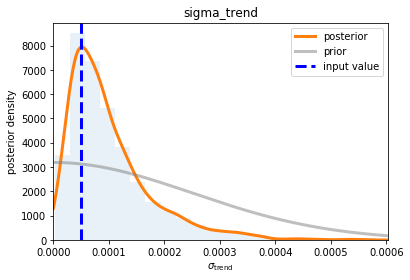

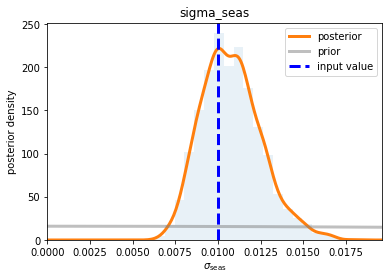

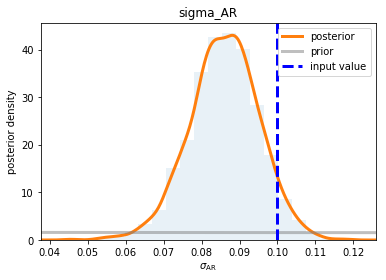

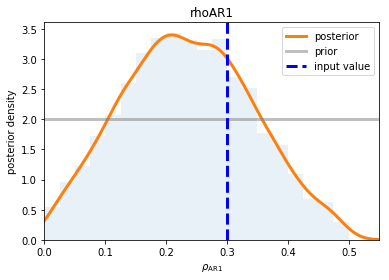

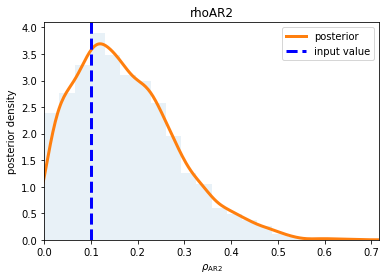

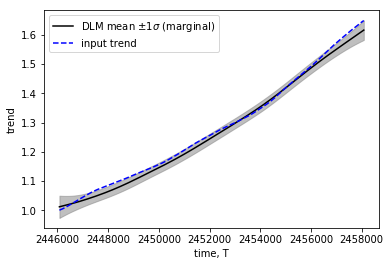

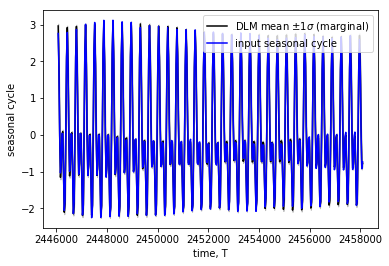

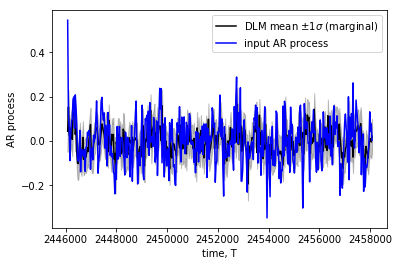

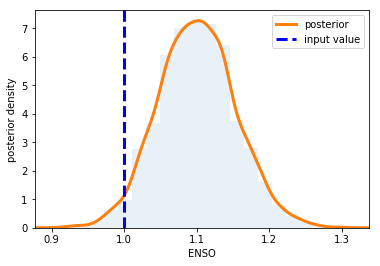

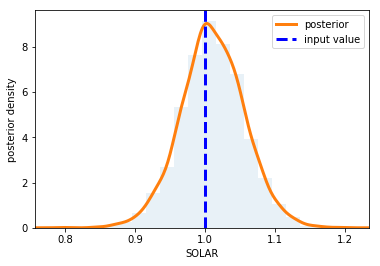

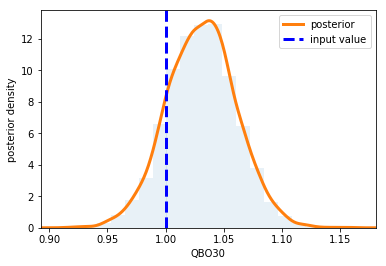

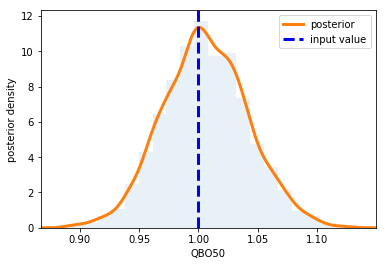

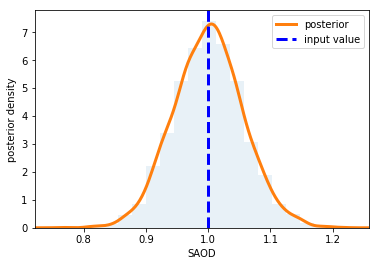

In [4]:
# Set the random seed for re-producebility
np.random.seed(0)

# Set the "true" input values of the hyper parameters for the test
sigma_trend = 5e-5
sigma_seas = 1e-2
sigma_AR = 0.1
rhoAR1 = 0.3
rhoAR2 = 0.1

# Set "true" input x0: initial value of state vector
nx = len(regressors.T)+8
x0 = np.concatenate([np.array([1, 1e-3]), np.ones(nx-2)])

# Set the standard deviations for the observational uncertainties
s = np.ones(nt+1)*0.1

# Set the prior parameters
S = 10. # Gaussian prior std-dev for initial state vector components x0
sigma_trend_prior = 2.5e-4
sigma_seas_prior = 5e-2
sigma_AR_prior = 0.5

# Generate realization of state x and observations y
x, d = simulate_x_y_dlm_vanilla_ar2(x0, sigma_trend, sigma_seas, sigma_AR, rhoAR1, rhoAR2, regressors, S, s**2, nt, nx)

# Pull the various components from the simulated state vector
trend = x[0,1:]
slope = x[1,1:]
seasonal_cycle = x[2,1:] + x[4,1:]
ar = x[-2,1:]
regressor_coefficients = x[6:6+len(regressors.T), 1]

# What is the range of the data (NB: hyper-parameters are defined in units of the rescaled data, ie., /(max(d) - min(d)) )
data_range = max(d[1:]) - min(d[1:])

# Import the DLM model
dlm_model = pickle.load(open('models/dlm_vanilla_ar2.pkl', 'rb'))

# Set the data and initialization of parameters that are fed into the DLM

# Input data: this is a dictionary of all of the data/inputs that the DLM model needs (descriptions below)
input_data = {
                    'time_series':d[1:], # float[N] data vector
                    'stddev':s[1:], # float[N] std-dev error bars
                    'N':len(d[1:]), # (int) number of time-steps in the time-series
                    'nreg':len(regressors.T), # (int) number of regressors
                    'regressors':regressors, # float[N, nreg] the regressors
                    'sampling':sampling_rate("monthly"), # must be "daily", "monthly", or "annual"
                    'S':S, # prior variance on the regression coefficients
                    'sigma_trend_prior':sigma_trend_prior/data_range, # std-dev of the half-Gaussian prior on sigma_trend
                    'sigma_seas_prior':sigma_seas_prior/data_range, # std-dev of the half-Gaussian prior on sigma_seas
                    'sigma_AR_prior':sigma_AR_prior/data_range # std-dev of the half_Gaussian prior on the AR1 process std-dev 
                }

# Initialization: Initial guess values for the hyper-parameters
initial_state = {
                 'sigma_trend':sigma_trend/data_range,
                 'sigma_seas':sigma_seas/data_range,
                 'sigma_AR':sigma_AR/data_range,
                 'rhoAR1':rhoAR1,
                 'rhoAR2':rhoAR2
                }

# Ok, let's run it
fit = dlm_model.sampling(data=input_data, iter=4000, warmup=1000, chains=1, init = [initial_state], verbose=True, pars=('sigma_trend', 'sigma_seas', 'sigma_AR', 'rhoAR1', 'rhoAR2', 'trend', 'slope', 'beta', 'seasonal', 'ar'))

# Plot the results:

# Plot posteriors for the DLM hyper parameters

sigma_trend_samples = fit.extract()['sigma_trend']*data_range
kde = stats.gaussian_kde(sigma_trend_samples)
x = np.linspace(0, max(sigma_trend_samples)*1.1, 300)
plt.hist(sigma_trend_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_trend_prior**2))*np.exp(-x**2/(2*sigma_trend_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_trend, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_trend')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{trend}$')
plt.legend()
plt.show()

sigma_seas_samples = fit.extract()['sigma_seas']*data_range
kde = stats.gaussian_kde(sigma_seas_samples)
x = np.linspace(0, max(sigma_seas_samples)*1.1, 300)
plt.hist(sigma_seas_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_seas_prior**2))*np.exp(-x**2/(2*sigma_seas_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_seas, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_seas')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{seas}$')
plt.legend()
plt.show()

sigma_AR_samples = fit.extract()['sigma_AR']*data_range
kde = stats.gaussian_kde(sigma_AR_samples)
x = np.linspace(min(sigma_AR_samples) - np.ptp(sigma_AR_samples)*0.1, max(sigma_AR_samples) + np.ptp(sigma_AR_samples)*0.1, 300)
plt.hist(sigma_AR_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_AR_prior**2))*np.exp(-x**2/(2*sigma_AR_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_AR, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_AR')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{AR}$')
plt.legend()
plt.show()

rhoAR1_samples = fit.extract()['rhoAR1']
kde = stats.gaussian_kde(rhoAR1_samples)
x = np.linspace(min(rhoAR1_samples) - np.ptp(rhoAR1_samples)*0.1, max(rhoAR1_samples) + np.ptp(rhoAR1_samples)*0.1, 300)
plt.hist(rhoAR1_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.axhline(1./0.5, lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(rhoAR1, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(0, x[-1])
plt.title('rhoAR1')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR1}$')
plt.legend()
plt.show()

rhoAR2_samples = fit.extract()['rhoAR2']
kde = stats.gaussian_kde(rhoAR2_samples)
x = np.linspace(min(rhoAR2_samples) - np.ptp(rhoAR2_samples)*0.1, max(rhoAR2_samples) + np.ptp(rhoAR2_samples)*0.1, 300)
plt.hist(rhoAR2_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.axvline(rhoAR2, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(0, x[-1])
plt.title('rhoAR2')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR2}$')
plt.legend()
plt.show()

# State variables...

# Trend
trend_samples = fit.extract()['trend'][:,:]
plt.plot(T, np.mean(trend_samples, axis = 0), color = 'black', label = r'DLM mean $\pm 1\sigma$ (marginal)')
plt.fill_between(T, np.mean(trend_samples, axis = 0) - np.std(trend_samples, axis = 0), np.mean(trend_samples, axis = 0) + np.std(trend_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, trend, label = 'input trend', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('trend')
plt.legend()
plt.show()

# Seasonal cycle
seasonal_cycle_samples = fit.extract()['seasonal'][:,:]
plt.plot(T, np.mean(seasonal_cycle_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(seasonal_cycle_samples, axis = 0) - np.std(seasonal_cycle_samples, axis = 0), np.mean(seasonal_cycle_samples, axis = 0) + np.std(seasonal_cycle_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, seasonal_cycle, label = 'input seasonal cycle', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('seasonal cycle')
plt.legend()
plt.show()

# AR
AR_samples = fit.extract()['ar'][:,:]
plt.plot(T, np.mean(AR_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(AR_samples, axis = 0) - np.std(AR_samples, axis = 0), np.mean(AR_samples, axis = 0) + np.std(AR_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, ar, label = 'input AR process', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('AR process')
plt.legend()
plt.show()

# Regressor coefficients
regressor_coefficients_samples = fit.extract()['beta'][:,:]
for i in range(len(regressors.T)):
    regressor_samples = regressor_coefficients_samples[:,i]
    kde = stats.gaussian_kde(regressor_samples)
    x = np.linspace(min(regressor_samples) - np.ptp(regressor_samples)*0.1, max(regressor_samples) + np.ptp(regressor_samples)*0.1, 300)
    plt.hist(regressor_samples, bins=20, density=True, alpha = 0.1)
    plt.plot(x, kde(x), lw = 3, label = 'posterior')
    plt.axvline(regressor_coefficients[i], ls = '--', lw = 3, color = 'blue', label = 'input value')
    plt.xlim(x[0], x[-1])
    plt.ylabel('posterior density')
    plt.xlabel(regressor_names[i])
    plt.legend()
    plt.show()

# Test 3: model `dlm_noregs_ar1`

## (1) Choose hyper-parameters and priors, generate random mock data realization
## (2) Fit DLM model to the mock data
## (3) Plot the inferred DLM model components against the (mock) inputs

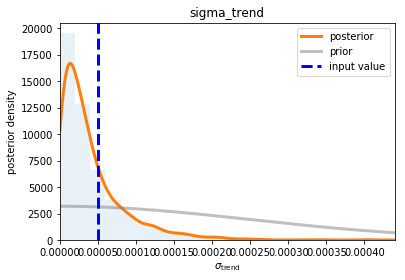

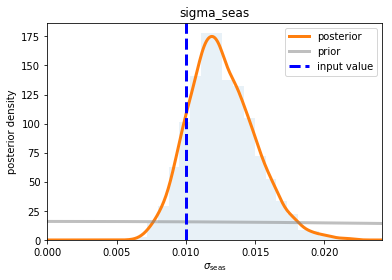

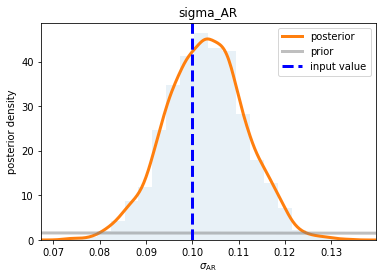

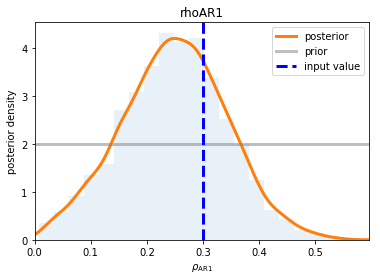

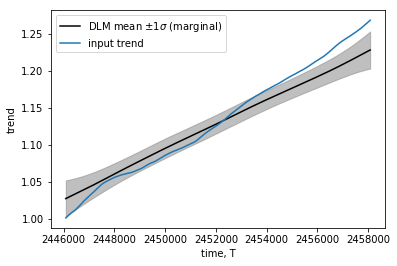

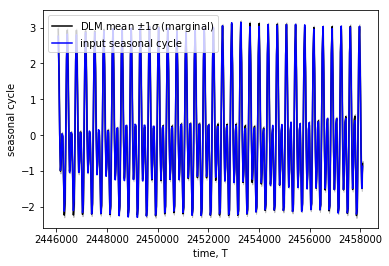

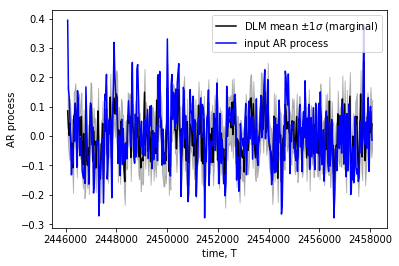

In [5]:
# Set the random seed for re-producebility
np.random.seed(0)

# Set the "true" input values of the hyper parameters for the test
sigma_trend = 5e-5
sigma_seas = 1e-2
sigma_AR = 0.1
rhoAR1 = 0.3

# Set "true" input x0: initial value of state vector
nx = 7
x0 = np.concatenate([np.array([1, 1e-3]), np.ones(nx-2)])

# Set the standard deviations for the observational uncertainties
s = np.ones(nt+1)*0.1

# Set the prior parameters
S = 10. # Gaussian prior std-dev for initial state vector components x0
sigma_trend_prior = 2.5e-4
sigma_seas_prior = 5e-2
sigma_AR_prior = 0.5

# Generate realization of state x and observations y
x, d = simulate_x_y_dlm_noregs_ar1(x0, sigma_trend, sigma_seas, sigma_AR, rhoAR1, S, s**2, nt, nx)

# Pull the various components from the simulated state vector
trend = x[0,1:]
slope = x[1,1:]
seasonal_cycle = x[2,1:] + x[4,1:]
ar = x[-1,1:]

# What is the range of the data (NB: hyper-parameters are defined in units of the rescaled data, ie., /(max(d) - min(d)) )
data_range = max(d[1:]) - min(d[1:])

# Import the DLM model
dlm_model = pickle.load(open('models/dlm_noregs_ar1.pkl', 'rb'))

# Set the data and initialization of parameters that are fed into the DLM

# Input data: this is a dictionary of all of the data/inputs that the DLM model needs (descriptions below)
input_data = {
                    'time_series':d[1:], # float[N] data vector
                    'stddev':s[1:], # float[N] std-dev error bars
                    'N':len(d[1:]), # (int) number of time-steps in the time-series
                    'sampling':sampling_rate("monthly"), # must be "daily", "monthly", or "annual"
                    'S':S, # prior variance on the regression coefficients
                    'sigma_trend_prior':sigma_trend_prior/data_range, # std-dev of the half-Gaussian prior on sigma_trend
                    'sigma_seas_prior':sigma_seas_prior/data_range, # std-dev of the half-Gaussian prior on sigma_seas
                    'sigma_AR_prior':sigma_AR_prior/data_range # std-dev of the half_Gaussian prior on the AR1 process std-dev 
                }

# Initialization: Initial guess values for the hyper-parameters
initial_state = {
                 'sigma_trend':sigma_trend/data_range,
                 'sigma_seas':sigma_seas/data_range,
                 'sigma_AR':sigma_AR/data_range,
                 'rhoAR1':rhoAR1,
                }

# Ok, let's run it
fit = dlm_model.sampling(data=input_data, iter=4000, warmup=1000, chains=1, init = [initial_state], verbose=True, pars=('sigma_trend', 'sigma_seas', 'sigma_AR', 'rhoAR1', 'trend', 'slope', 'seasonal', 'ar'))

# Plot the results:

# Plot posteriors for the DLM hyper parameters

sigma_trend_samples = fit.extract()['sigma_trend']*data_range
kde = stats.gaussian_kde(sigma_trend_samples)
x = np.linspace(0, max(sigma_trend_samples)*1.1, 300)
plt.hist(sigma_trend_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_trend_prior**2))*np.exp(-x**2/(2*sigma_trend_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_trend, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_trend')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{trend}$')
plt.legend()
plt.show()

sigma_seas_samples = fit.extract()['sigma_seas']*data_range
kde = stats.gaussian_kde(sigma_seas_samples)
x = np.linspace(0, max(sigma_seas_samples)*1.1, 300)
plt.hist(sigma_seas_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_seas_prior**2))*np.exp(-x**2/(2*sigma_seas_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_seas, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_seas')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{seas}$')
plt.legend()
plt.show()

sigma_AR_samples = fit.extract()['sigma_AR']*data_range
kde = stats.gaussian_kde(sigma_AR_samples)
x = np.linspace(min(sigma_AR_samples) - np.ptp(sigma_AR_samples)*0.1, max(sigma_AR_samples) + np.ptp(sigma_AR_samples)*0.1, 300)
plt.hist(sigma_AR_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_AR_prior**2))*np.exp(-x**2/(2*sigma_AR_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_AR, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_AR')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{AR}$')
plt.legend()
plt.show()

rhoAR1_samples = fit.extract()['rhoAR1']
kde = stats.gaussian_kde(rhoAR1_samples)
x = np.linspace(min(rhoAR1_samples) - np.ptp(rhoAR1_samples)*0.1, max(rhoAR1_samples) + np.ptp(rhoAR1_samples)*0.1, 300)
plt.hist(rhoAR1_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.axhline(1./0.5, lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(rhoAR1, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(0, x[-1])
plt.title('rhoAR1')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR1}$')
plt.legend()
plt.show()

# State variables...

# Trend
trend_samples = fit.extract()['trend'][:,:]
plt.plot(T, np.mean(trend_samples, axis = 0), color = 'black', label = r'DLM mean $\pm 1\sigma$ (marginal)')
plt.fill_between(T, np.mean(trend_samples, axis = 0) - np.std(trend_samples, axis = 0), np.mean(trend_samples, axis = 0) + np.std(trend_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, trend, label = 'input trend')
plt.xlabel('time, T')
plt.ylabel('trend')
plt.legend()
plt.show()

# Seasonal cycle
seasonal_cycle_samples = fit.extract()['seasonal'][:,:]
plt.plot(T, np.mean(seasonal_cycle_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(seasonal_cycle_samples, axis = 0) - np.std(seasonal_cycle_samples, axis = 0), np.mean(seasonal_cycle_samples, axis = 0) + np.std(seasonal_cycle_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, seasonal_cycle, label = 'input seasonal cycle', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('seasonal cycle')
plt.legend()
plt.show()

# AR
AR_samples = fit.extract()['ar'][:,:]
plt.plot(T, np.mean(AR_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(AR_samples, axis = 0) - np.std(AR_samples, axis = 0), np.mean(AR_samples, axis = 0) + np.std(AR_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, ar, label = 'input AR process', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('AR process')
plt.legend()
plt.show()

# Test 4: model `dlm_dynregs_ar1`

## (1) Choose hyper-parameters and priors, generate random mock data realization
## (2) Fit DLM model to the mock data
## (3) Plot the inferred DLM model components against the (mock) inputs

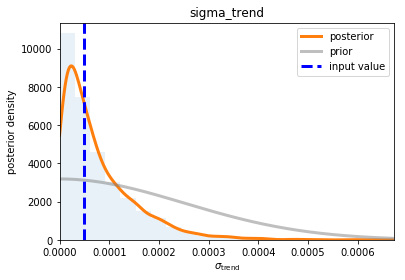

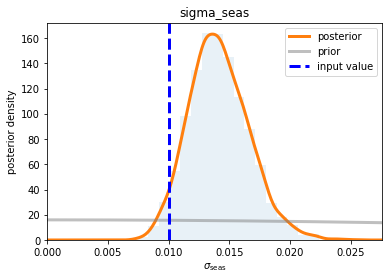

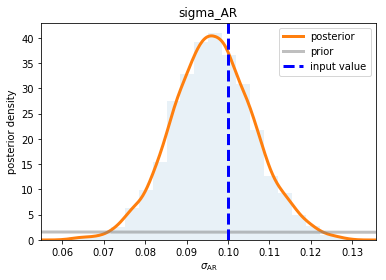

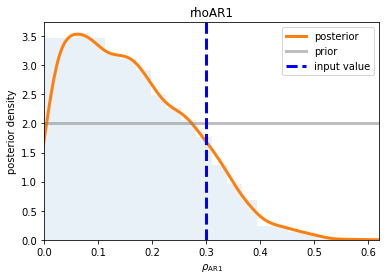

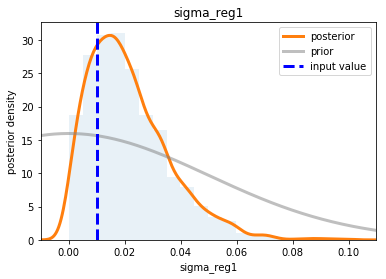

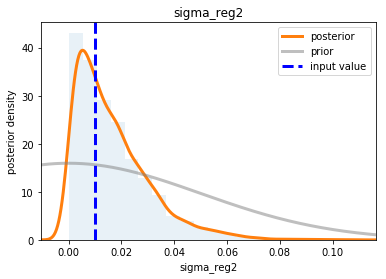

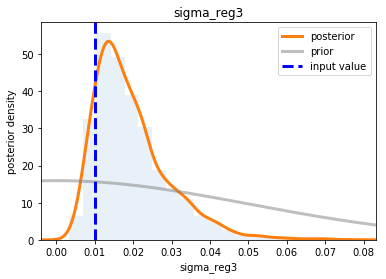

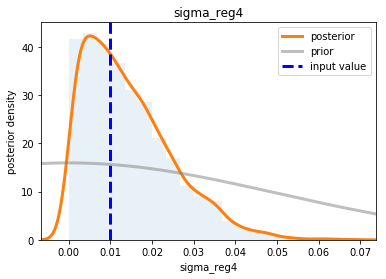

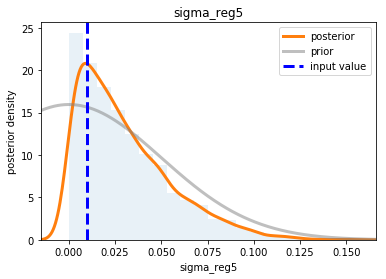

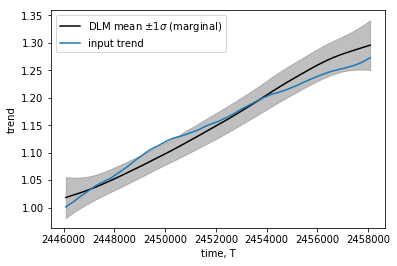

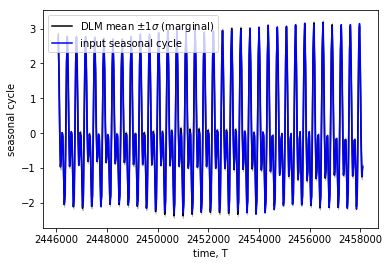

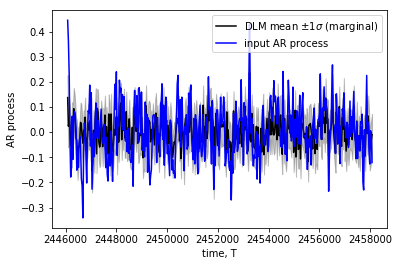

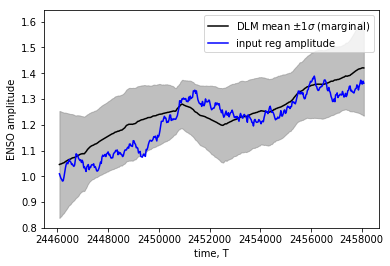

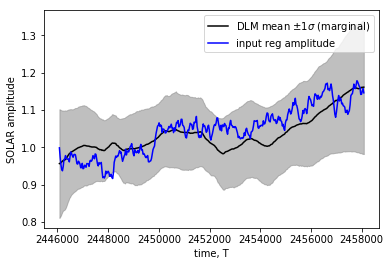

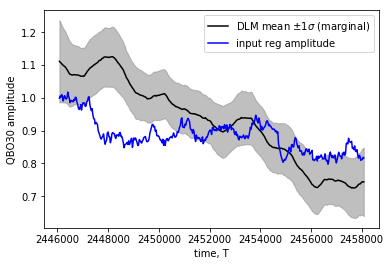

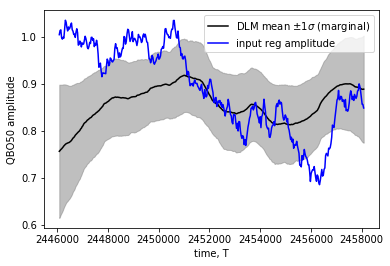

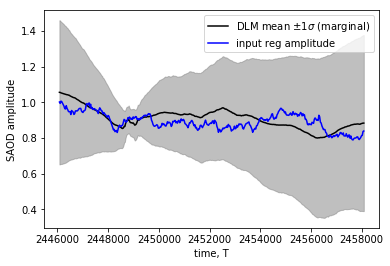

In [6]:
# Set the random seed for re-producebility
np.random.seed(0)

# Set the "true" input values of the hyper parameters for the test
sigma_trend = 5e-5
sigma_seas = 1e-2
sigma_AR = 0.1
sigma_reg = 1e-2*np.ones(len(regressors.T))
rhoAR1 = 0.3

# Set "true" input x0: initial value of state vector
nx = len(regressors.T)+7
x0 = np.concatenate([np.array([1, 1e-3]), np.ones(nx-2)])

# Set the standard deviations for the observational uncertainties
s = np.ones(nt+1)*0.1

# Set the prior parameters
S = 10. # Gaussian prior std-dev for initial state vector components x0
sigma_trend_prior = 2.5e-4
sigma_seas_prior = 5e-2
sigma_AR_prior = 0.5
sigma_reg_prior = np.ones(len(regressors.T))*5e-2

# Generate realization of state x and observations y
x, d = simulate_x_y_dlm_dynregs_ar1(x0, sigma_trend, sigma_seas, sigma_AR, rhoAR1, sigma_reg, regressors, S, s**2, nt, nx)

# Pull the various components from the simulated state vector
trend = x[0,1:]
slope = x[1,1:]
seasonal_cycle = x[2,1:] + x[4,1:]
ar = x[-1,1:]
regressor_coefficients = x[6:6+len(regressors.T), 1:]

# What is the range of the data (NB: hyper-parameters are defined in units of the rescaled data, ie., /(max(d) - min(d)) )
data_range = max(d[1:]) - min(d[1:])

# Import the DLM model
dlm_model = pickle.load(open('models/dlm_dynregs_ar1.pkl', 'rb'))

# Set the data and initialization of parameters that are fed into the DLM

# Input data: this is a dictionary of all of the data/inputs that the DLM model needs (descriptions below)
input_data = {
                    'time_series':d[1:], # float[N] data vector
                    'stddev':s[1:], # float[N] std-dev error bars
                    'N':len(d[1:]), # (int) number of time-steps in the time-series
                    'nreg':len(regressors.T), # (int) number of regressors
                    'regressors':regressors, # float[N, nreg] the regressors
                    'sampling':sampling_rate("monthly"), # must be "daily", "monthly", or "annual"
                    'S':S/data_range, # prior variance on the regression coefficients
                    'sigma_trend_prior':sigma_trend_prior/data_range, # std-dev of the half-Gaussian prior on sigma_trend
                    'sigma_seas_prior':sigma_seas_prior/data_range, # std-dev of the half-Gaussian prior on sigma_seas
                    'sigma_AR_prior':sigma_AR_prior/data_range, # std-dev of the half_Gaussian prior on the AR1 process std-dev 
                    'sigma_reg_prior':sigma_reg_prior/data_range
}

# Initialization: Initial guess values for the hyper-parameters
initial_state = {
                 'sigma_trend':sigma_trend/data_range,
                 'sigma_seas':sigma_seas/data_range,
                 'sigma_AR':sigma_AR/data_range,
                 'rhoAR1':rhoAR1,
                 'sigma_reg':sigma_reg/data_range
                }

# Ok, let's run it
fit = dlm_model.sampling(data=input_data, iter=4000, warmup=1000, chains=1, init = [initial_state], verbose=True, pars=('sigma_trend', 'sigma_seas', 'sigma_AR', 'sigma_reg', 'rhoAR1', 'trend', 'slope', 'beta', 'seasonal', 'ar'))

# Plot the results:

# Plot posteriors for the DLM hyper parameters

sigma_trend_samples = fit.extract()['sigma_trend']*data_range
kde = stats.gaussian_kde(sigma_trend_samples)
x = np.linspace(0, max(sigma_trend_samples)*1.1, 300)
plt.hist(sigma_trend_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_trend_prior**2))*np.exp(-x**2/(2*sigma_trend_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_trend, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_trend')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{trend}$')
plt.legend()
plt.show()

sigma_seas_samples = fit.extract()['sigma_seas']*data_range
kde = stats.gaussian_kde(sigma_seas_samples)
x = np.linspace(0, max(sigma_seas_samples)*1.1, 300)
plt.hist(sigma_seas_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_seas_prior**2))*np.exp(-x**2/(2*sigma_seas_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_seas, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_seas')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{seas}$')
plt.legend()
plt.show()

sigma_AR_samples = fit.extract()['sigma_AR']*data_range
kde = stats.gaussian_kde(sigma_AR_samples)
x = np.linspace(min(sigma_AR_samples) - np.ptp(sigma_AR_samples)*0.1, max(sigma_AR_samples) + np.ptp(sigma_AR_samples)*0.1, 300)
plt.hist(sigma_AR_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.plot(x, np.sqrt(2./(np.pi*sigma_AR_prior**2))*np.exp(-x**2/(2*sigma_AR_prior**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(sigma_AR, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(x[0], x[-1])
plt.title('sigma_AR')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{AR}$')
plt.legend()
plt.show()

rhoAR1_samples = fit.extract()['rhoAR1']
kde = stats.gaussian_kde(rhoAR1_samples)
x = np.linspace(min(rhoAR1_samples) - np.ptp(rhoAR1_samples)*0.1, max(rhoAR1_samples) + np.ptp(rhoAR1_samples)*0.1, 300)
plt.hist(rhoAR1_samples, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3, label = 'posterior')
plt.axhline(1./0.5, lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
plt.axvline(rhoAR1, ls = '--', lw = 3, color = 'blue', label = 'input value')
plt.xlim(0, x[-1])
plt.title('rhoAR1')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR1}$')
plt.legend()
plt.show()

for i in range(len(regressors.T)):
    sigma_reg_samples = fit.extract()['sigma_reg'][:,i]*data_range
    kde = stats.gaussian_kde(sigma_reg_samples)
    x = np.linspace(min(sigma_reg_samples) - np.ptp(sigma_reg_samples)*0.1, max(sigma_reg_samples) + np.ptp(sigma_reg_samples)*0.1, 300)
    plt.hist(sigma_reg_samples, bins=20, density=True, alpha = 0.1)
    plt.plot(x, kde(x), lw = 3, label = 'posterior')
    plt.plot(x, np.sqrt(2./(np.pi*sigma_reg_prior[i]**2))*np.exp(-x**2/(2*sigma_reg_prior[i]**2)), lw = 3, color = 'grey', alpha = 0.5, label = 'prior')
    plt.axvline(sigma_reg[i], ls = '--', lw = 3, color = 'blue', label = 'input value')
    plt.xlim(x[0], x[-1])
    plt.title('sigma_reg{}'.format(i+1))
    plt.ylabel('posterior density')
    plt.xlabel('sigma_reg{}'.format(i+1))
    plt.legend()
    plt.show() 


# State variables...

# Trend
trend_samples = fit.extract()['trend'][:,:]
plt.plot(T, np.mean(trend_samples, axis = 0), color = 'black', label = r'DLM mean $\pm 1\sigma$ (marginal)')
plt.fill_between(T, np.mean(trend_samples, axis = 0) - np.std(trend_samples, axis = 0), np.mean(trend_samples, axis = 0) + np.std(trend_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, trend, label = 'input trend')
plt.xlabel('time, T')
plt.ylabel('trend')
plt.legend()
plt.show()

# Seasonal cycle
seasonal_cycle_samples = fit.extract()['seasonal'][:,:]
plt.plot(T, np.mean(seasonal_cycle_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(seasonal_cycle_samples, axis = 0) - np.std(seasonal_cycle_samples, axis = 0), np.mean(seasonal_cycle_samples, axis = 0) + np.std(seasonal_cycle_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, seasonal_cycle, label = 'input seasonal cycle', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('seasonal cycle')
plt.legend()
plt.show()

# AR
AR_samples = fit.extract()['ar'][:,:]
plt.plot(T, np.mean(AR_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
plt.fill_between(T, np.mean(AR_samples, axis = 0) - np.std(AR_samples, axis = 0), np.mean(AR_samples, axis = 0) + np.std(AR_samples, axis = 0), color = 'grey', alpha = 0.5)
plt.plot(T, ar, label = 'input AR process', color = 'blue')
plt.xlabel('time, T')
plt.ylabel('AR process')
plt.legend()
plt.show()

# Dynamical regressor amplitudes
for i in range(len(regressors.T)):
    reg_samples = fit.extract()['beta'][:,:,i]
    plt.plot(T, np.mean(reg_samples, axis = 0), label = r'DLM mean $\pm 1\sigma$ (marginal)', color = 'black')
    plt.fill_between(T, np.mean(reg_samples, axis = 0) - np.std(reg_samples, axis = 0), np.mean(reg_samples, axis = 0) + np.std(reg_samples, axis = 0), color = 'grey', alpha = 0.5)
    plt.plot(T, regressor_coefficients[i,:], label = 'input reg amplitude', color = 'blue')
    plt.xlabel('time, T')
    plt.ylabel('{} amplitude'.format(regressor_names[i]))
    plt.legend()
    plt.show()